In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
loader = transforms.Compose([
    transforms.Resize(size = (512, 512)),  
    transforms.ToTensor()])  


def image_loader(image_name):
    image = Image.open(image_name)
    
    image = loader(image).unsqueeze(0)
    
    return image.to(device, torch.float)


style_img = image_loader("E:/DIP project/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg")
content_img = image_loader("E:/DIP project/68fc62ae-fc42-43a1-99c7-bbaa8055e140.jpg")

if style_img.size() != content_img.size():
    print("Need size Equal")
    
print(style_img.size(),content_img.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


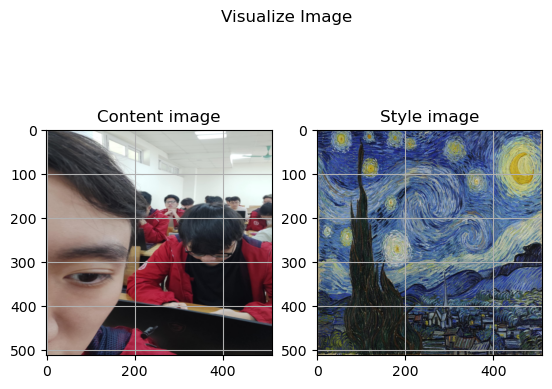

In [12]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow2(tensor1, tensor2):
    content = tensor1.cpu().clone()
    style = tensor2.cpu().clone()

    content = content.squeeze(0)
    style = style.squeeze(0)

    content = unloader(content)
    style = unloader(style)

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(content)
    ax[0].set_title("Content image")
    ax[0].grid()

    ax[1].imshow(style)
    ax[1].set_title("Style image")
    ax[1].grid()

    fig.suptitle("Visualize Image")

    plt.pause(0.001)

imshow2(content_img, style_img)



In [13]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
    
def gram_matrix(input):
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a feature map (N=c*d)
    a, b, c, d = input.size()  
    

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [14]:
# mean and standard deviation from the data set
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [15]:
import torch.nn.utils as utils

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)


    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            layer = utils.weight_norm(layer)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            layer = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [16]:

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
content_loss_val = []
style_loss_val = []
loss_val = []

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            # clear the previous gradient
            optimizer.zero_grad()
            # feed in the input img
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
                
            for cl in content_losses:
                content_score += cl.loss
                

            style_score *= style_weight
            content_score *= content_weight

            style_loss_val.append(style_score.item())
            content_loss_val.append(content_score.item())

            loss = style_score + content_score
            loss_val.append(loss)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img




In [18]:

input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
nput_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:


output= run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300)


Building the style transfer model..
Optimizing..


C:\Users\Windows\AppData\Local\Temp\ipykernel_1088\2132929398.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Windows\AppData\Local\Temp\ipykernel_1088\2132929398.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 1.759255 Content Loss: 7.315166

run [100]:
Style Loss : 0.448449 Content Loss: 6.106954

run [150]:
Style Loss : 0.356810 Content Loss: 5.769959

run [200]:
Style Loss : 0.356507 Content Loss: 5.650647

run [250]:
Style Loss : 0.330105 Content Loss: 5.602654

run [300]:
Style Loss : 0.338833 Content Loss: 5.602832



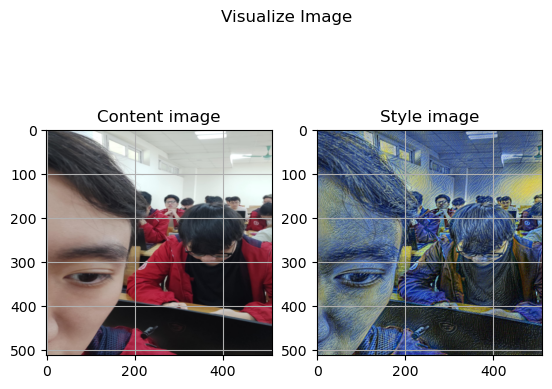

In [19]:
imshow2(content_img, output)

In [20]:
len(content_loss_val), len(style_loss_val)

(320, 320)

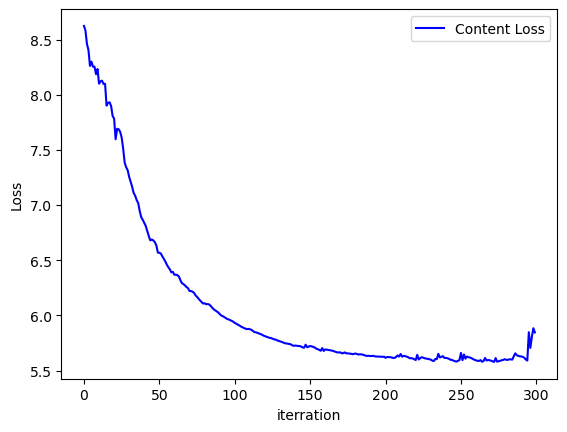

In [21]:
plt.plot(range(300), content_loss_val[20:], c = "b", label = "Content Loss")
plt.legend()
plt.xlabel("iterration")
plt.ylabel("Loss")
plt.show()


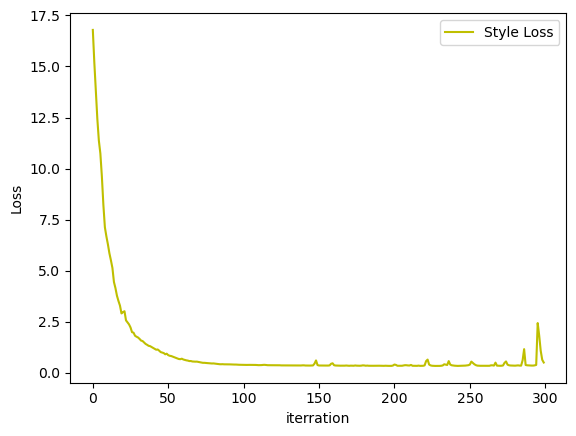

In [22]:
plt.plot(range(300), style_loss_val[20:], c = "y", label = "Style Loss")
plt.legend()
plt.xlabel("iterration")
plt.ylabel("Loss")
plt.show()

In [23]:
loss_values = [val.item() for val in loss_val]
loss_values

[2144.723388671875,
 2144.649169921875,
 935.6690063476562,
 702.4053955078125,
 501.6419372558594,
 275.41741943359375,
 191.54148864746094,
 117.76422119140625,
 97.20335388183594,
 82.7269287109375,
 69.72093963623047,
 55.33814239501953,
 44.596763610839844,
 40.581382751464844,
 35.875614166259766,
 34.29787063598633,
 31.836196899414062,
 29.265560150146484,
 28.328693389892578,
 26.887853622436523,
 25.415756225585938,
 23.7706356048584,
 22.305530548095703,
 20.828086853027344,
 19.632801055908203,
 19.03792381286621,
 17.86490249633789,
 16.47123146057129,
 15.307010650634766,
 14.907058715820312,
 14.386146545410156,
 13.968864440917969,
 13.631132125854492,
 13.225297927856445,
 12.541316986083984,
 12.043301582336426,
 11.695613861083984,
 11.441518783569336,
 11.184185981750488,
 10.71010971069336,
 10.747873306274414,
 10.604968070983887,
 10.252010345458984,
 10.147895812988281,
 10.02830696105957,
 9.827204704284668,
 9.495157241821289,
 9.342272758483887,
 9.1488809585

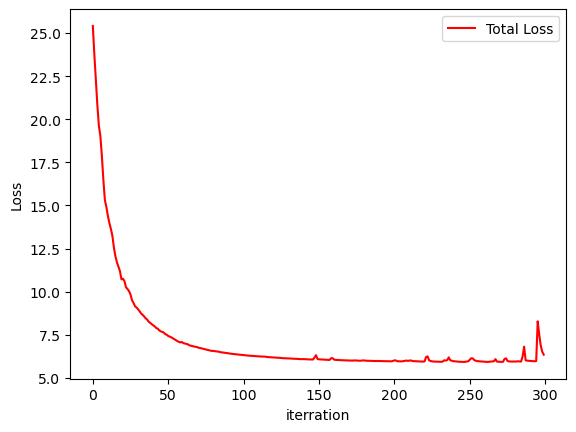

In [24]:
plt.plot(range(300), loss_values[20:], c = "r", label = "Total Loss")
plt.legend()
plt.xlabel("iterration")
plt.ylabel("Loss")
plt.show()

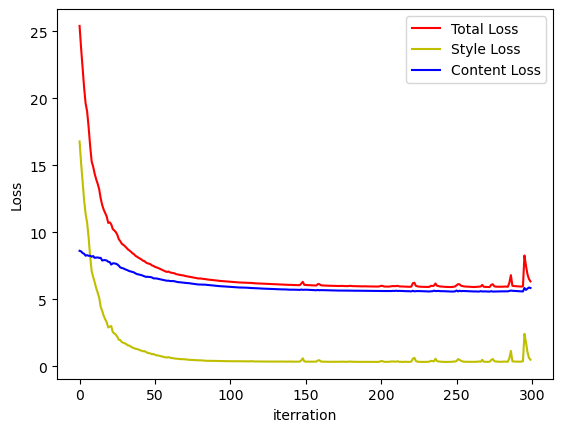

In [25]:
plt.plot(range(300), loss_values[20:], c = "r", label = "Total Loss")
plt.plot(range(300), style_loss_val[20:], c = "y", label = "Style Loss")
plt.plot(range(300), content_loss_val[20:], c = "b", label = "Content Loss")
plt.legend()
plt.xlabel("iterration")
plt.ylabel("Loss")
plt.show()

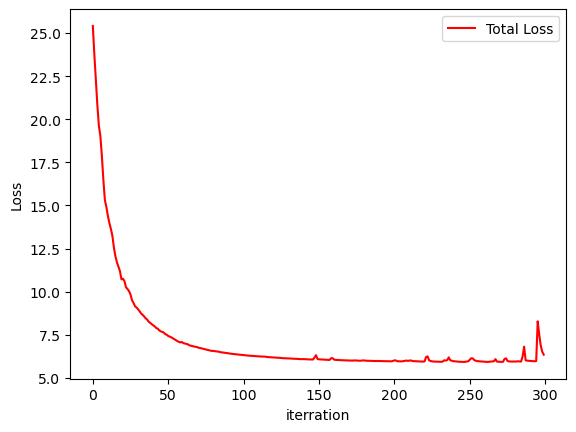

In [26]:
plt.plot(range(300), loss_values[20:], c = "r", label = "Total Loss")
plt.legend()
plt.xlabel("iterration")
plt.ylabel("Loss")
plt.show()

In [27]:
import pandas as pd
import numpy as np

def to_numpy(value):
        return np.array(torch.Tensor(value).numpy())


def visualize_last_loss(content_loss, style_loss, loss):
    a = to_numpy(content_loss)
    b = to_numpy(style_loss)
    c = to_numpy(loss)

    loss1 = []
    loss2 = []
    loss3 = []
    
    for i in a:
          loss1.append(round(i,4))
    for i in b:
          loss2.append(round(i,4))
    for i in c:
          loss3.append(round(i,4))

    data = {
        "Content Loss": loss1,
        "Style Loss": loss2,
        "Loss": loss3
    }
    return pd.DataFrame(data=data)

df = visualize_last_loss(content_loss_val, style_loss_val, loss_val)
last = df.iloc[-1]
df = df.iloc[20:]

last_df = pd.DataFrame(last).T  
last_df.columns = df.columns
last_df


,Content Loss,Style Loss,Loss
319,5.8455,0.4959,6.3413


In [28]:
df

,Content Loss,Style Loss,Loss
20,8.6236,16.7922,25.415800
21,8.5818,15.1889,23.770599
22,8.4588,13.8468,22.305500
23,8.4047,12.4234,20.828100
24,8.2610,11.3718,19.632799
...,...,...,...
315,5.8476,2.4284,8.275900
316,5.7050,1.8100,7.515100
317,5.8033,1.0694,6.872700
318,5.8834,0.6300,6.513300


In [29]:
df.describe()

,Content Loss,Style Loss,Loss
count,300.000000,300.000000,300.000000
mean,6.072862,1.030489,7.103349
std,0.735194,2.158837,2.780002
min,5.578000,0.329000,5.919500
25%,5.623375,0.344975,5.974075
50%,5.720300,0.365800,6.108450
75%,6.171125,0.565550,6.731125
max,8.623600,16.792200,25.415800


In [30]:
output_image = output.cpu().clone()
output_image = output_image.squeeze(0)
output_image = unloader(output_image)
output_image.save('output_image.jpg')